# Code example

In this notebook, we will demonstrate the use of our complexity methods by applying them to a single patient. It covers the entire process of reading in the data, applying the complexity methods and visualizing the results. This should allow anyone to reproduce all results presented in our paper, but should also allow one to apply the same methods to their own activity sequences and interpret the results. 

In [23]:
import numpy as np

from lib import helpers
from lib import complexity
%load_ext autoreload 
%autoreload 1
%aimport lib.helpers
%aimport lib.complexity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
patient_id = 1 # select any patient id, ranging from 1 - 7

## Reading in the activity counts 

In [12]:
df = helpers.read_counts(patient_id)

In [14]:
df.head()

,counts
Time,
2021-03-16 20:00:00,47.267814
2021-03-16 20:01:00,62.365239
2021-03-16 20:02:00,28.549592
2021-03-16 20:03:00,61.734361
2021-03-16 20:04:00,65.136725


In [65]:
mean, std = helpers.calculate_mean_std(df)

In [73]:
print("Mean of daily activity counts: %.3f" %mean)
print("Std of daily activity counts: %.3f" %std)

Mean of daily activity counts: 54268.543
Std of daily activity counts: 11659.484


## Static fractal dimension

We will first use the AAA method to obtain the fractal dimension for the full 3-week activity sequence, for a range of scales. Then, we will also calculate the fractal dimensions for the first, second and third week, again for a range of scales. 

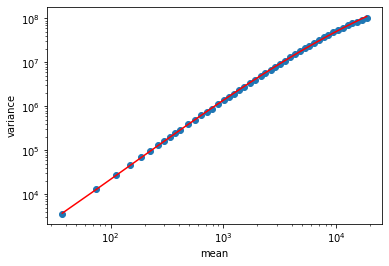

In [20]:
counts_sequence = np.array(df["counts"])
n_min = 1 # minimal scale of 1 minute
n_max = 9*60 # maximal scale of 9 hours
fractal_dim, scales = complexity.adapted_allometric_aggregation(counts_sequence, n_min, n_max)

We can visualize the variation of the fractal dimension across scales (we only show scales higher than the 30-minute mark, which is index 18 in the array).

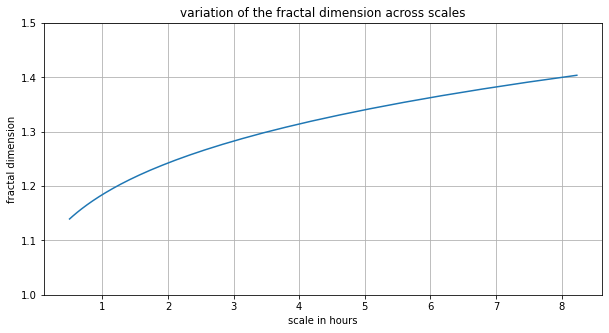

In [42]:
helpers.visualize_across_scales(scales[18:], fractal_dim[18:])

In [38]:
len_week = 60*24*7 # one week contains this amount of 1-minute counts intervals

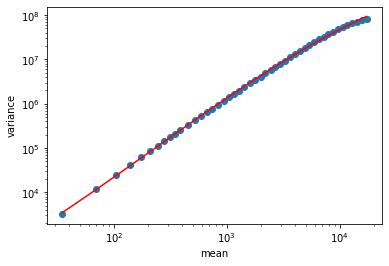

In [39]:
fractal_dim_week1, scales = complexity.adapted_allometric_aggregation(counts_sequence[:len_week], n_min, n_max)

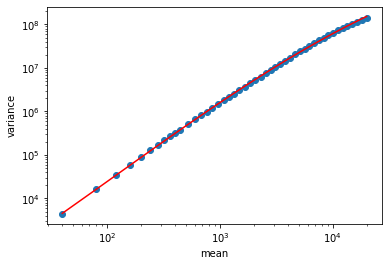

In [40]:
fractal_dim_week2, scales = complexity.adapted_allometric_aggregation(counts_sequence[len_week:2*len_week], n_min, n_max)

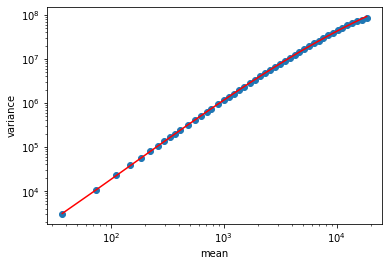

In [41]:
fractal_dim_week3, scales = complexity.adapted_allometric_aggregation(counts_sequence[2*len_week:], n_min, n_max)

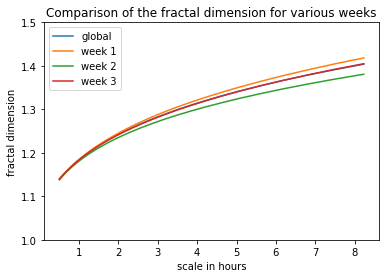

In [48]:
fractal_dim_dict = {"full":fractal_dim, "week1":fractal_dim_week1, "week2":fractal_dim_week2, "week3":fractal_dim_week3}
helpers.compare_static_dims(scales, fractal_dim_dict)

In [49]:
scales

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  15,
        17,  19,  21,  24,  27,  30,  33,  37,  41,  46,  51,  57,  63,
        70,  77,  85,  94, 104, 115, 127, 140, 154, 170, 188, 207, 228,
       251, 277, 305, 336, 370, 408, 449, 494])

The "scales" array tells us that the value for the 3-hour scale (approximately), can be found at the following index: 

In [55]:
idx = np.where(scales==188)[0][0]
print(idx)

36


In [63]:
name = "patient"+str(patient_id)
print("comparison of static fractal dimensions for patient "+str(patient_id)+"\n")
print("global\tweek1\tweek2\tweek3\t\tmean\tstd")
print("------------------------------------------------------")
mean = np.mean([fractal_dim_dict["week1"][idx], fractal_dim_dict["week2"][idx], fractal_dim_dict["week3"][idx]])
std = np.std([fractal_dim_dict["week1"][idx], fractal_dim_dict["week2"][idx], fractal_dim_dict["week3"][idx]])
print("%.3f\t%.3f\t%.3f\t%.3f\t\t%.3f\t%.3f" %(fractal_dim_dict["full"][idx], fractal_dim_dict["week1"][idx], fractal_dim_dict["week2"][idx], fractal_dim_dict["week3"][idx], mean, std))

comparison of static fractal dimensions for patient 1

global	week1	week2	week3		mean	std
------------------------------------------------------
1.287	1.293	1.276	1.287		1.285	0.007


## Evolution fractal dimension

We can now apply the time-dependent complexity method to get an evolution of the fractal dimension over time, again for various scales. We use a window width of 3 days. We will then plot the evolution and compare it to the static fractal dimensions calculated previously.

**REMOVE THE FOLLOWING FOUR CELLS**

In [78]:
import pickle
with open("C:\\Users\\Paloma\\Work\\bds-predictive-modeling\\time_dependent_compl\\evolution_3days_CFS.pickle", 'rb') as handle:
    evolution_3days = pickle.load(handle)

In [89]:
evolution_compl = np.array(evolution_3days["patient1"][0])

In [90]:
evolution_times = np.array(evolution_3days["patient1"][1])

In [97]:
window_width = "3 days"
step_size = "5 min"

**RUN FROM HERE ON**

In [ ]:
window_width = "3 days"
step_size = "5 min"
n_min = 1
n_max = 9*60
evolution_compl, evolution_times, scales = complexity_evolution(df, window_width, step_size, n_min, n_max)

We can get the ranking of the three weeks in terms of general functioning from the file "data/functioning.md". **Please take note that this list needs to be changed accordingly when selecting another patient.**

In [91]:
functioning = [2, 0, 1] # ranking of the three weeks in terms of functioning (2 = worst week, 0 = best week, 1 = avg week)

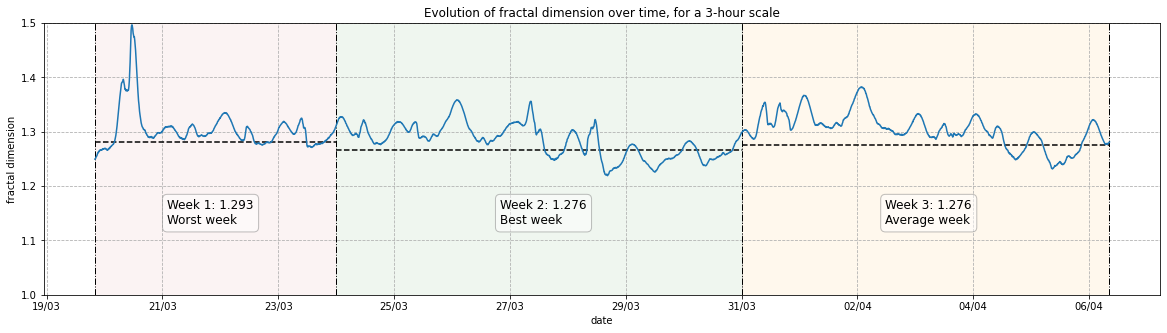

In [95]:
helpers.plot_complexity_evolution(evolution_compl, evolution_times, fractal_dim_dict, functioning, 1.13)

## Correlation with activity

Finally, we can calculate the correlations between the fractal dimension obtained within each 3-day window and the total sum of the activity counts recorded in that window. 

First, we need to generate the evolution of the activity counts, again using a 3-day window. 

In [104]:
evolution_activity, activity_times = helpers.sliding_window_activity(df, window_width, step_size)

Now, we can compare the obtained fractal dimension evolution with the evolution of the aggregated counts. The timestamps are automatically lined up, since we used the same parameters for both the complexity_evolution function and the sliding_window_activity function. 

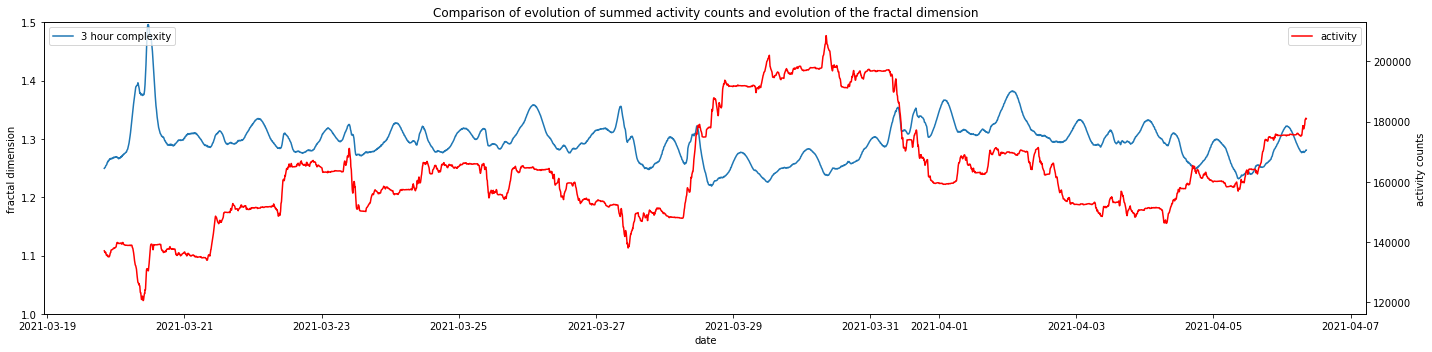

In [111]:
helpers.plot_activity_complexity(evolution_compl, evolution_activity, evolution_times)

By sampling both signals three times a day, and comparing the corresponding samples, we can obtain the Pearson correlation between the two metrics, as well as plot the scatter plot of their relation.

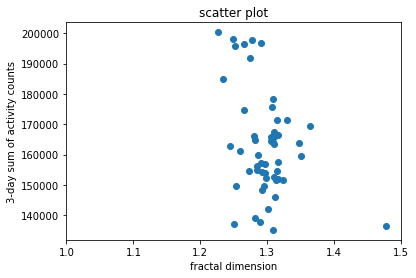

In [120]:
corr = helpers.scatter_activity_complexity(evolution_compl, evolution_activity)

In [121]:
print(corr)

-0.3754918051762303
